In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score

In [2]:
df = pd.read_csv('train (1).csv', names=["json ID", "label", "statement", "subject", "speaker", "job title", "state", "party",
                         "barely true", "false", "half true", "mostly true", "pantson fire","context"])

In [3]:
# Drop unnecessary columns
df = df[['label', 'statement']]

In [4]:
# Preprocess the data
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
X = df['statement']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Tokenize the text
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [6]:
# Pad the sequences
X_train = pad_sequences(X_train, maxlen=100)
X_test = pad_sequences(X_test, maxlen=100)

In [7]:
# Build the model
model = Sequential()
model.add(Embedding(5000, 100, input_length=100))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          500000    
                                                                 
 conv1d (Conv1D)             (None, 98, 64)            19264     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                        

In [8]:
# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, callbacks=[early_stop])

Epoch 1/50
128/128 [==============================] - 3s 18ms/step - loss: 1.7586 - accuracy: 0.2068 - val_loss: 1.7412 - val_accuracy: 0.2207
Epoch 2/50
128/128 [==============================] - 2s 17ms/step - loss: 1.6930 - accuracy: 0.2992 - val_loss: 1.7227 - val_accuracy: 0.2402
Epoch 3/50
128/128 [==============================] - 2s 17ms/step - loss: 1.4774 - accuracy: 0.4481 - val_loss: 1.7874 - val_accuracy: 0.2192
Epoch 4/50
128/128 [==============================] - 2s 17ms/step - loss: 1.0294 - accuracy: 0.6725 - val_loss: 1.9964 - val_accuracy: 0.2280
Epoch 5/50
128/128 [==============================] - 2s 17ms/step - loss: 0.5267 - accuracy: 0.8573 - val_loss: 2.3640 - val_accuracy: 0.2148


In [9]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.2148


In [10]:
# Make predictions on the test set and calculate evaluation metrics
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

64/64 [==============================] - 0s 3ms/step


In [11]:
print(y_test.shape)
print(y_pred.shape)

(2048,)
(2048, 6)


In [12]:
print(classification_report(y_test, y_pred_labels))

              precision    recall  f1-score   support

           0       0.24      0.26      0.25       401
           1       0.20      0.20      0.20       340
           2       0.22      0.20      0.21       339
           3       0.20      0.26      0.23       438
           4       0.23      0.17      0.20       382
           5       0.19      0.11      0.14       148

    accuracy                           0.21      2048
   macro avg       0.21      0.20      0.20      2048
weighted avg       0.22      0.21      0.21      2048



Confusion Matrix:
[[106  62  62 106  50  15]
 [ 52  69  35 109  63  12]
 [ 71  50  67 102  39  10]
 [102  75  64 116  62  19]
 [ 66  70  53 115  66  12]
 [ 41  23  26  35   7  16]]


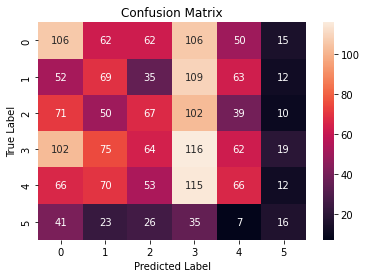

In [13]:
cm = confusion_matrix(y_test, y_pred_labels)
print(f'Confusion Matrix:\n{cm}')
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

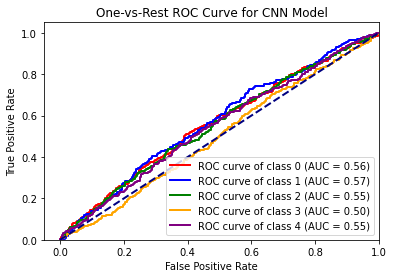

In [24]:
y_test.shape 
y_pred.shape 

n_classes = y_pred.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot one-vs-rest ROC curve for each class
plt.figure()
colors = ['red', 'blue', 'green', 'orange', 'purple'] # customize colors as needed
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest ROC Curve for CNN Model')
plt.legend(loc="lower right")
plt.show()
